In [1]:
import pandas as pd
import numpy as np
import joypy
import matplotlib.pyplot as plt
import glob
from pyfonts import load_google_font
from drawarrow import ax_arrow, fig_arrow
from pypalettes import load_cmap
from pyfonts import load_google_font
from highlight_text import ax_text, fig_text

## Data loading and cleaning

In [2]:
def clean_amount_values(amount):
    ''' enter an amount (e.g. '€89.20m',
    get it back wihtout the euro sign,
    without m / bn suffix 
    as a float '''
    output = amount.replace('€','')

    if 'bn' in output:
        output = float(output.replace('bn','')) * 1000
    elif 'm' in output:
        output = float(output.replace('m',''))
    elif 'k' in output:
        output = float(output.replace('k','')) / 1000
        
    return output

In [3]:
dfs = {}
for file in glob.glob('../data/*.csv'):
    
    league = (file.removeprefix('../data/')
              .removesuffix('.csv'))

    one_df = (pd.read_csv(file)
     .pipe(lambda df_: df_.assign(year=pd.to_datetime('20' + df_['season'].astype(str).str[-2:], format='%Y').dt.year))
     .set_index('year')
     .assign(squad_val_m = lambda df_: df_['squad_total_val'].apply(clean_amount_values),
            plyaer_mean_val_m = lambda df_: df_['player_mean_value'].apply(clean_amount_values))
     .sort_index()
     .pivot(index='club', columns = 'season', values = 'squad_val_m'))

    dfs[league] = one_df

## Colors and fonts

In [457]:
font = load_google_font('Lato')
title = load_google_font('Oswald')
subheader = load_google_font('Merriweather')
background_c = '#F5F5DC'
league_colors = ['#D10214', '#0578FF', '#FF4B44', '#924bce', '#b7e204']
#                    DE         IT       ES         EN          FR
default_c = '#5454CE' 
cmap = load_cmap("AsteroidCity2") # for some of the gini visualisations

## Ridgeline

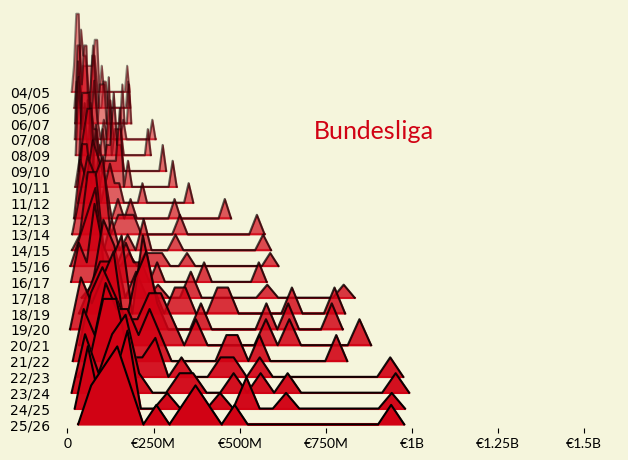

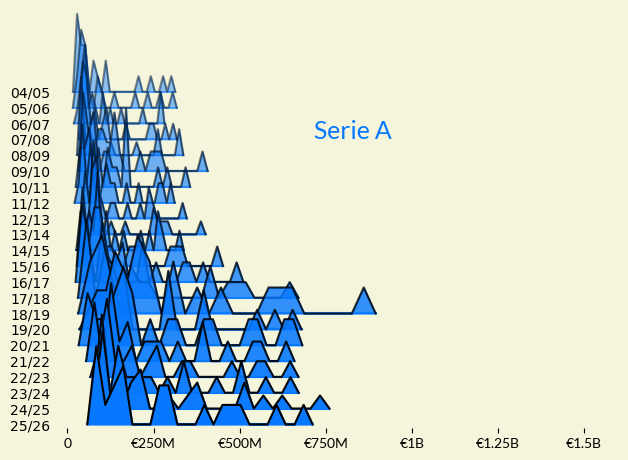

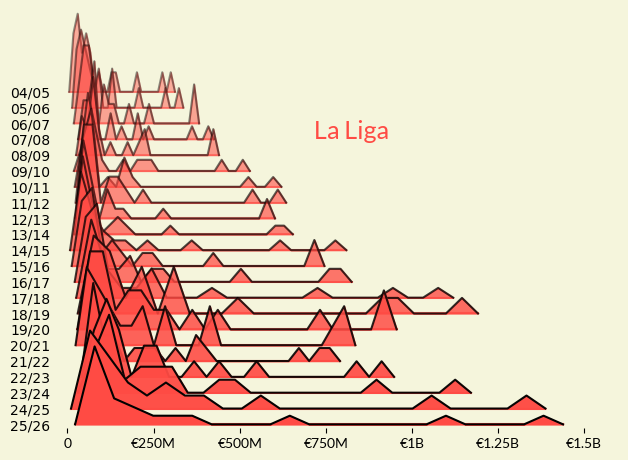

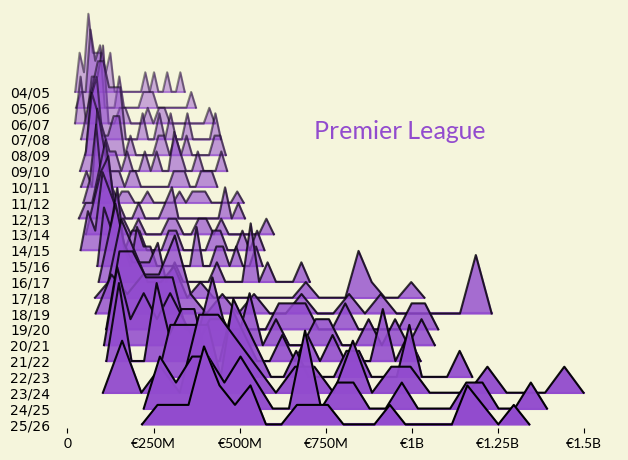

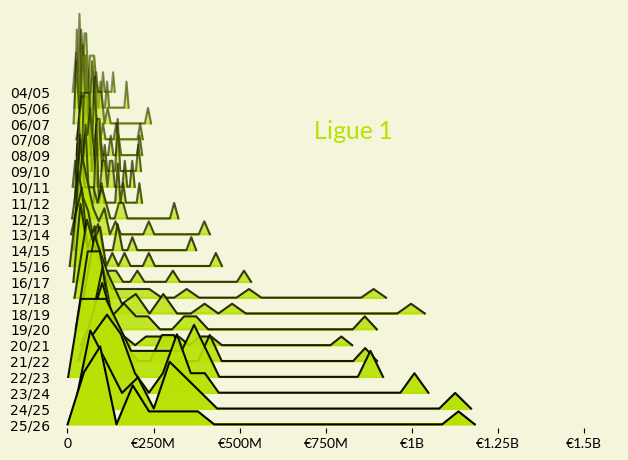

In [438]:
joyplot_style = {'overlap':1.12,
                 'x_range': [-10,1600],
                 'range_style':'own',
                 'kind': 'counts', 
                 'bins': 26,
                 'fade': True,
                 'tails': 0.05,
                 'ylim':'own',
                 'ylabels': True,
                 # 'xlabels': False,
                 #'linewidth': 0.75,
                 ## COLORS ##
                 'background':background_c,
                 'linecolor':'k',
}

for i, (league, color) in enumerate(zip(dfs, league_colors)):
    fig, axs = joypy.joyplot(
    dfs[league],
    color = color,
    **joyplot_style,
)
    fig.text(x= 0.5, y = 0.7, s=f"{league}", fontsize = 18, color = color, font = font)
    
    bottom_ax = axs[-1]
    for tick in bottom_ax.get_xticklabels():
        tick.set_color("k")
        tick.set_fontproperties(font)
    bottom_ax.set_xticks(np.arange(0,1501,250),
                        ['0','€250M' ,'€500M','€750M','€1B','€1.25B','€1.5B'])


    # for ax in axs[:-1:21]:             # all ridge axes
    #     for tick in ax.get_yticklabels():
    #         tick.set_color("k")
    #         tick.set_fontproperties(font)
        
    fig.set_facecolor('#F5F5DC')

    #be}_withall_ticks.svg', bbox_inches='tight')

## Ginis

### Function and defintions

In [439]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x). *Don't* pass in huge
    # samples!)
    
    x = np.asarray(x)
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

for league in dfs:
    print(f"{league:16} {gini(dfs[league]['25/26'].dropna())}")

Bundesliga       0.39414073800378646
Serie A          0.3691187273205945
La Liga          0.5414967067174348
Premier League   0.27516176354194183
Ligue 1          0.5049375942943355


In [440]:
ginis = {}
for league in dfs:
    ginis[league] = []
    for col in dfs[league].columns:
        ginis[league].append(gini(dfs[league][col].dropna()))

ginis_df = pd.DataFrame(ginis, index = dfs['La Liga'].columns)
ginis_df.head(3)

,Bundesliga,Serie A,La Liga,Premier League,Ligue 1
season,,,,,
04/05,0.323355,0.445441,0.482216,0.361316,0.276259
05/06,0.278308,0.434640,0.436189,0.338640,0.275097
06/07,0.306252,0.386053,0.420012,0.363678,0.320869


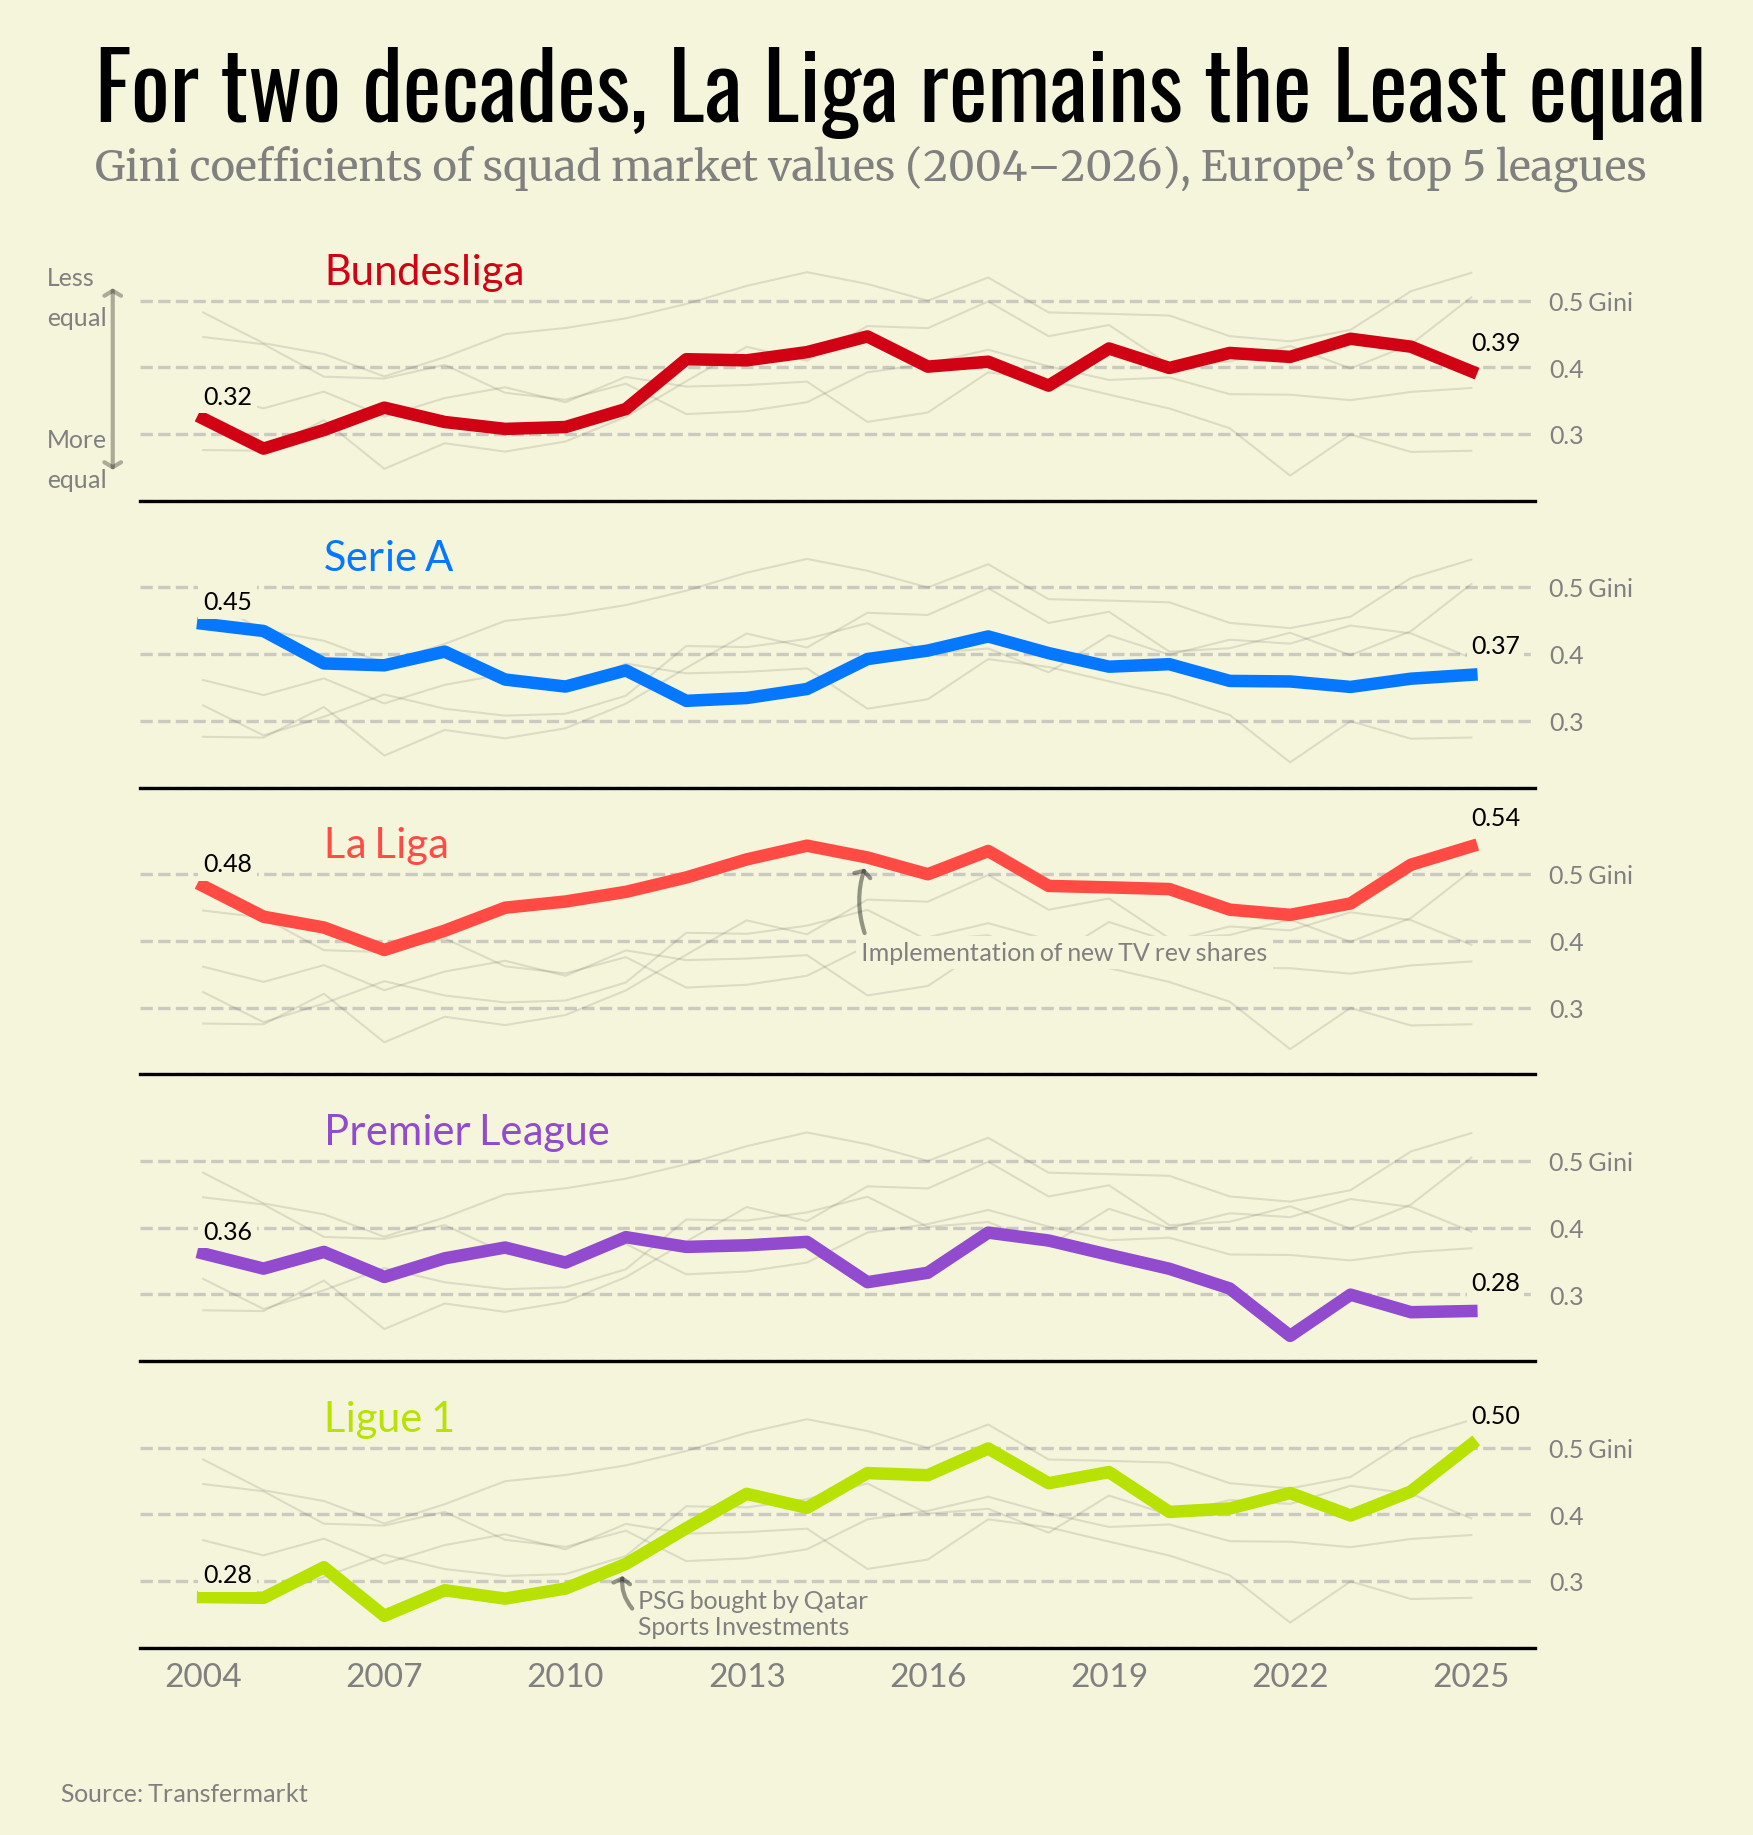

In [482]:
fig, axs = plt.subplots(5,1, figsize = (6, 6),dpi = 300)

for i, (league, color) in enumerate(zip(ginis_df.columns,league_colors)):
    axs[i].plot(ginis_df, c = 'black', lw = 0.5, alpha = 0.1)
    axs[i].plot(ginis_df[league], lw = 3, c = color)
    axs[i].set_facecolor(background_c)
    axs[i].spines[['top','left','right']].set_visible(False)
    axs[i].set_xticks([])
    axs[i].set_yticks(np.arange(0.2,0.6,0.1),
                     ['','0.3','0.4','0.5 Gini'],
                     font = font, ha = 'left',
                     color = 'grey', fontsize = 6)
    axs[i].grid('y', ls = '--', alpha = 0.62)
    axs[i].tick_params(length = 0)
    axs[i].yaxis.tick_right()
    axs[i].text(2,0.525,f'{league}', color = color, font = font)

    ax_text(0,
           ginis_df[league].iloc[0]+0.05, 
           f'<{ginis_df[league].iloc[0]:.2f}>', 
            fontsize = 6, font = font, 
            highlight_textprops=[{"bbox":{'facecolor':background_c,
                                          'linewidth':0,
                                          'pad':1.25}}],
           ax = axs[i])
           
    ax_text(21,
           ginis_df[league].iloc[-1]+0.06, 
           f'<{ginis_df[league].iloc[-1]:.2f}>', 
            fontsize = 6, font = font, 
            highlight_textprops=[{"bbox":{'facecolor':background_c,
                                          'linewidth':0,
                                          'pad':1}}],
           ax = axs[i])          
           
           
axs[-1].set_xticks(ginis_df.index[::3],
                   '20'+pd.Series(ginis_df.index[::3]).str[:-3],
                  color = 'grey', font = font,
                  fontsize = 8)

fig.set_facecolor(background_c)
fig_text(0.1,1, "For two decades, La Liga remains the Least equal", font = title, fontsize = 22)
fig_text(0.1,0.945, "Gini coefficients of squad market values (2004–2026), Europe’s top 5 leagues", 
         font = subheader, color = 'grey')

axs[-1].xaxis.grid(False)

annotation_dict = {'font':font, 'fontsize':6,
                  'color':'grey', 'zorder':4}

axs[-1].text(7.2, 0.22, 'PSG bought by Qatar\nSports Investments', 
             ha = 'left', **annotation_dict)
ax_arrow((7.2,0.25),(6.97,0.32),ax=axs[-1], 
         fill_head=False, head_length=1.2, head_width=2, 
         alpha = 0.4, radius = -0.3, zorder = 4)

ax_text(10.9,0.4, "<Implementation of new TV rev shares>", ax = axs[2], 
        **annotation_dict,
        highlight_textprops=[{"bbox":{'facecolor':background_c,
                                     'linewidth':0,
                                     'pad':1.25}}])
ax_arrow((11,0.4),(11,0.52),ax=axs[2], fill_head=False, 
         head_length=1.2, head_width=2, alpha = 0.4, radius = -0.2,
        zorder = 4)


fig_text(0.09, 0.86, 'Less\nequal', ha = 'center', va = 'center', **annotation_dict)
fig_text(0.09, 0.77, 'More\nequal', ha = 'center', va = 'center', **annotation_dict)


fig_arrow((0.11,0.76),(0.11,0.87),
         double_headed=True, fill_head=False, 
        head_length=1.2, head_width=2, 
        alpha = 0.3,
         zorder = 4)
fig.text(0.15,0.025, s = "Source: Transfermarkt",
           ha = 'center', font = font, fontsize = 6, color = 'grey')
#fig.savefig('multilines.png', bbox_inches='tight', dpi = 300)
plt.show()

### Visualisations

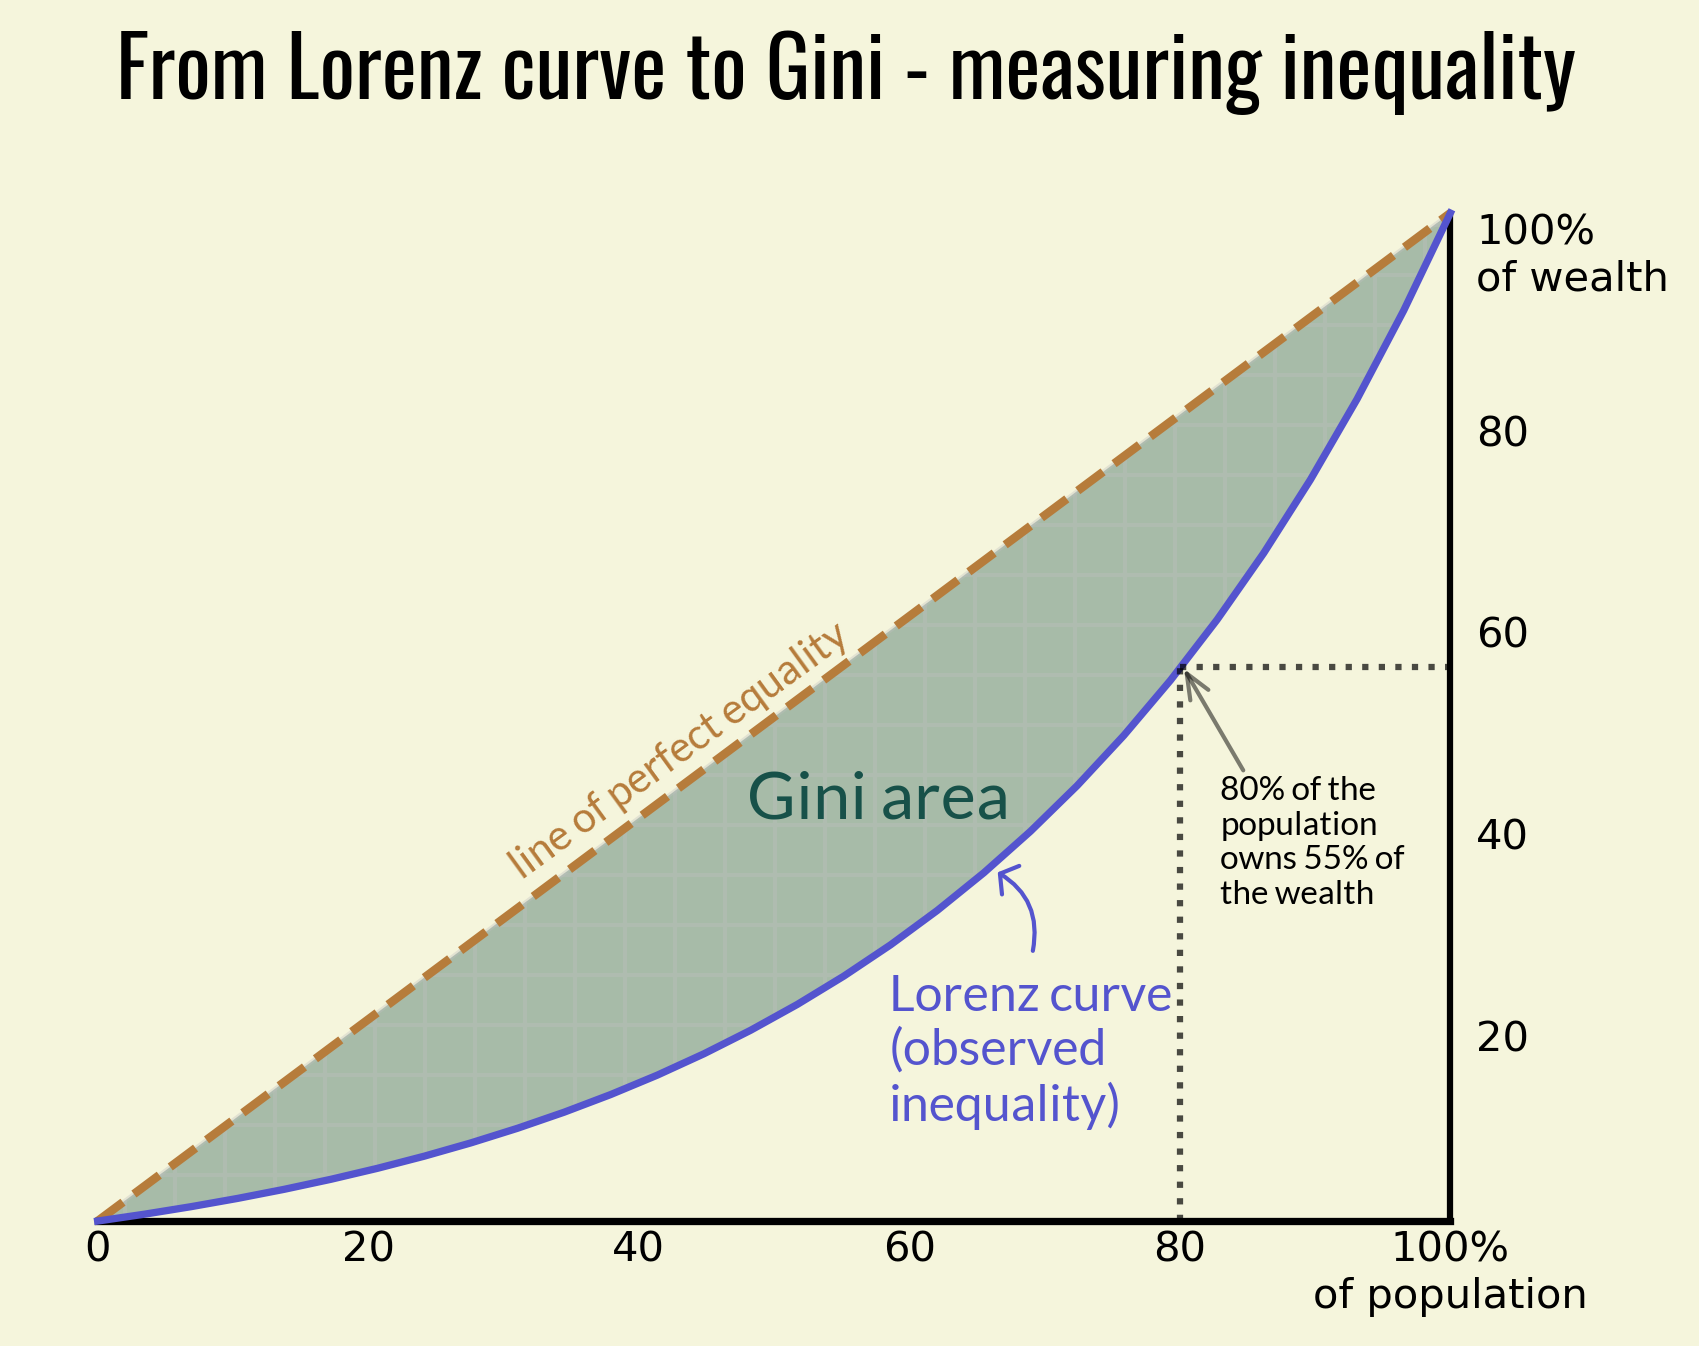

In [446]:
per = np.linspace(0, 1, 30)
imper = np.array([0]*30)
quin = np.linspace(0, 1, 30) #quin = quintiles
k = 2.75
lorenz = (np.exp(k * quin) - 1) / (np.exp(k) - 1)

fig, ax = plt.subplots( dpi = 300)

ax.plot(quin, per, lw = 2.05, ls = '--', color = cmap.colors[-3])       # Perfect line
ax.plot(quin, imper, lw = 1.75, color = 'k')                            # x line
ax.vlines(1,0,1, color = 'black', alpha = 1)                            # y line
ax.plot(quin, lorenz,lw = 1.75, color = default_c)                      # Lorenz line
ax.fill_between(per, per, lorenz, alpha=0.35,                           # fill area between lorenz and perfect lines
                color = cmap.colors[-2],
                hatch = '+', edgecolor='silver')

# Call outs and annotation
fig.text(0.55,0.925,"From Lorenz curve to Gini - measuring inequality",  # Title
        ha = 'center', font = title, fontsize = 20)
ax.text(x= 0.3, y = 0.34, s = 'line of perfect equality',               # Perfect line annotation
        c = cmap.colors[-3], rotation =36, size = 10, font = font)
ax.text(x= 0.585, y = 0.1, s = 'Lorenz curve\n(observed\ninequality)',  # Lorenz curve annotation
         c = default_c, rotation = 0, size = 12, font = font)
ax.text(x= 0.48, y = 0.4, s = 'Gini area', 
        c = cmap.colors[-2], rotation =0, size = 16, font = font)

ax_arrow(head_position=(0.66,0.35), tail_position=(0.69,0.26),         # Lorenz arrow 
         color = default_c, fill_head=False, 
         radius = 0.4, head_length=3)
ax_arrow(head_position=(0.80,0.555), tail_position=(0.85,0.44),        # callout arrow of example
         color = 'k', fill_head=False,
         head_width=2.5, head_length=6, alpha = 0.5)

vlines_properties = {'ls':'dotted','color':'k','alpha':0.7}
ax.vlines(0.8,0,0.555, **vlines_properties)                            # callout example vertical line
ax.hlines(0.55,0.80,1, **vlines_properties)                            # callout example horizontal line
ax.text(x= 0.83, y = 0.315,                                            # callout example horizontal text
        s = '80% of the\npopulation\nowns 55% of\nthe wealth',
        c = 'k', rotation = 0, size = 8, font = font, ha = 'left')

ax.set_yticks(np.arange(0.2,1.2,0.2),[20,40,60,80,'100%\nof wealth'], va = 'top')
ax.set_xticks(np.arange(0,1.2,0.2),[0,20,40,60,80,'100%\nof population'], va = 'top')
ax.yaxis.set_label_position("right")
ax.yaxis.label.set(rotation='horizontal', ha='left')
ax.yaxis.tick_right()
ax.tick_params(pad = -10, length = 0)
ax.spines[:].set_visible(False)

ax.set_facecolor(background_c)
fig.set_facecolor(background_c)

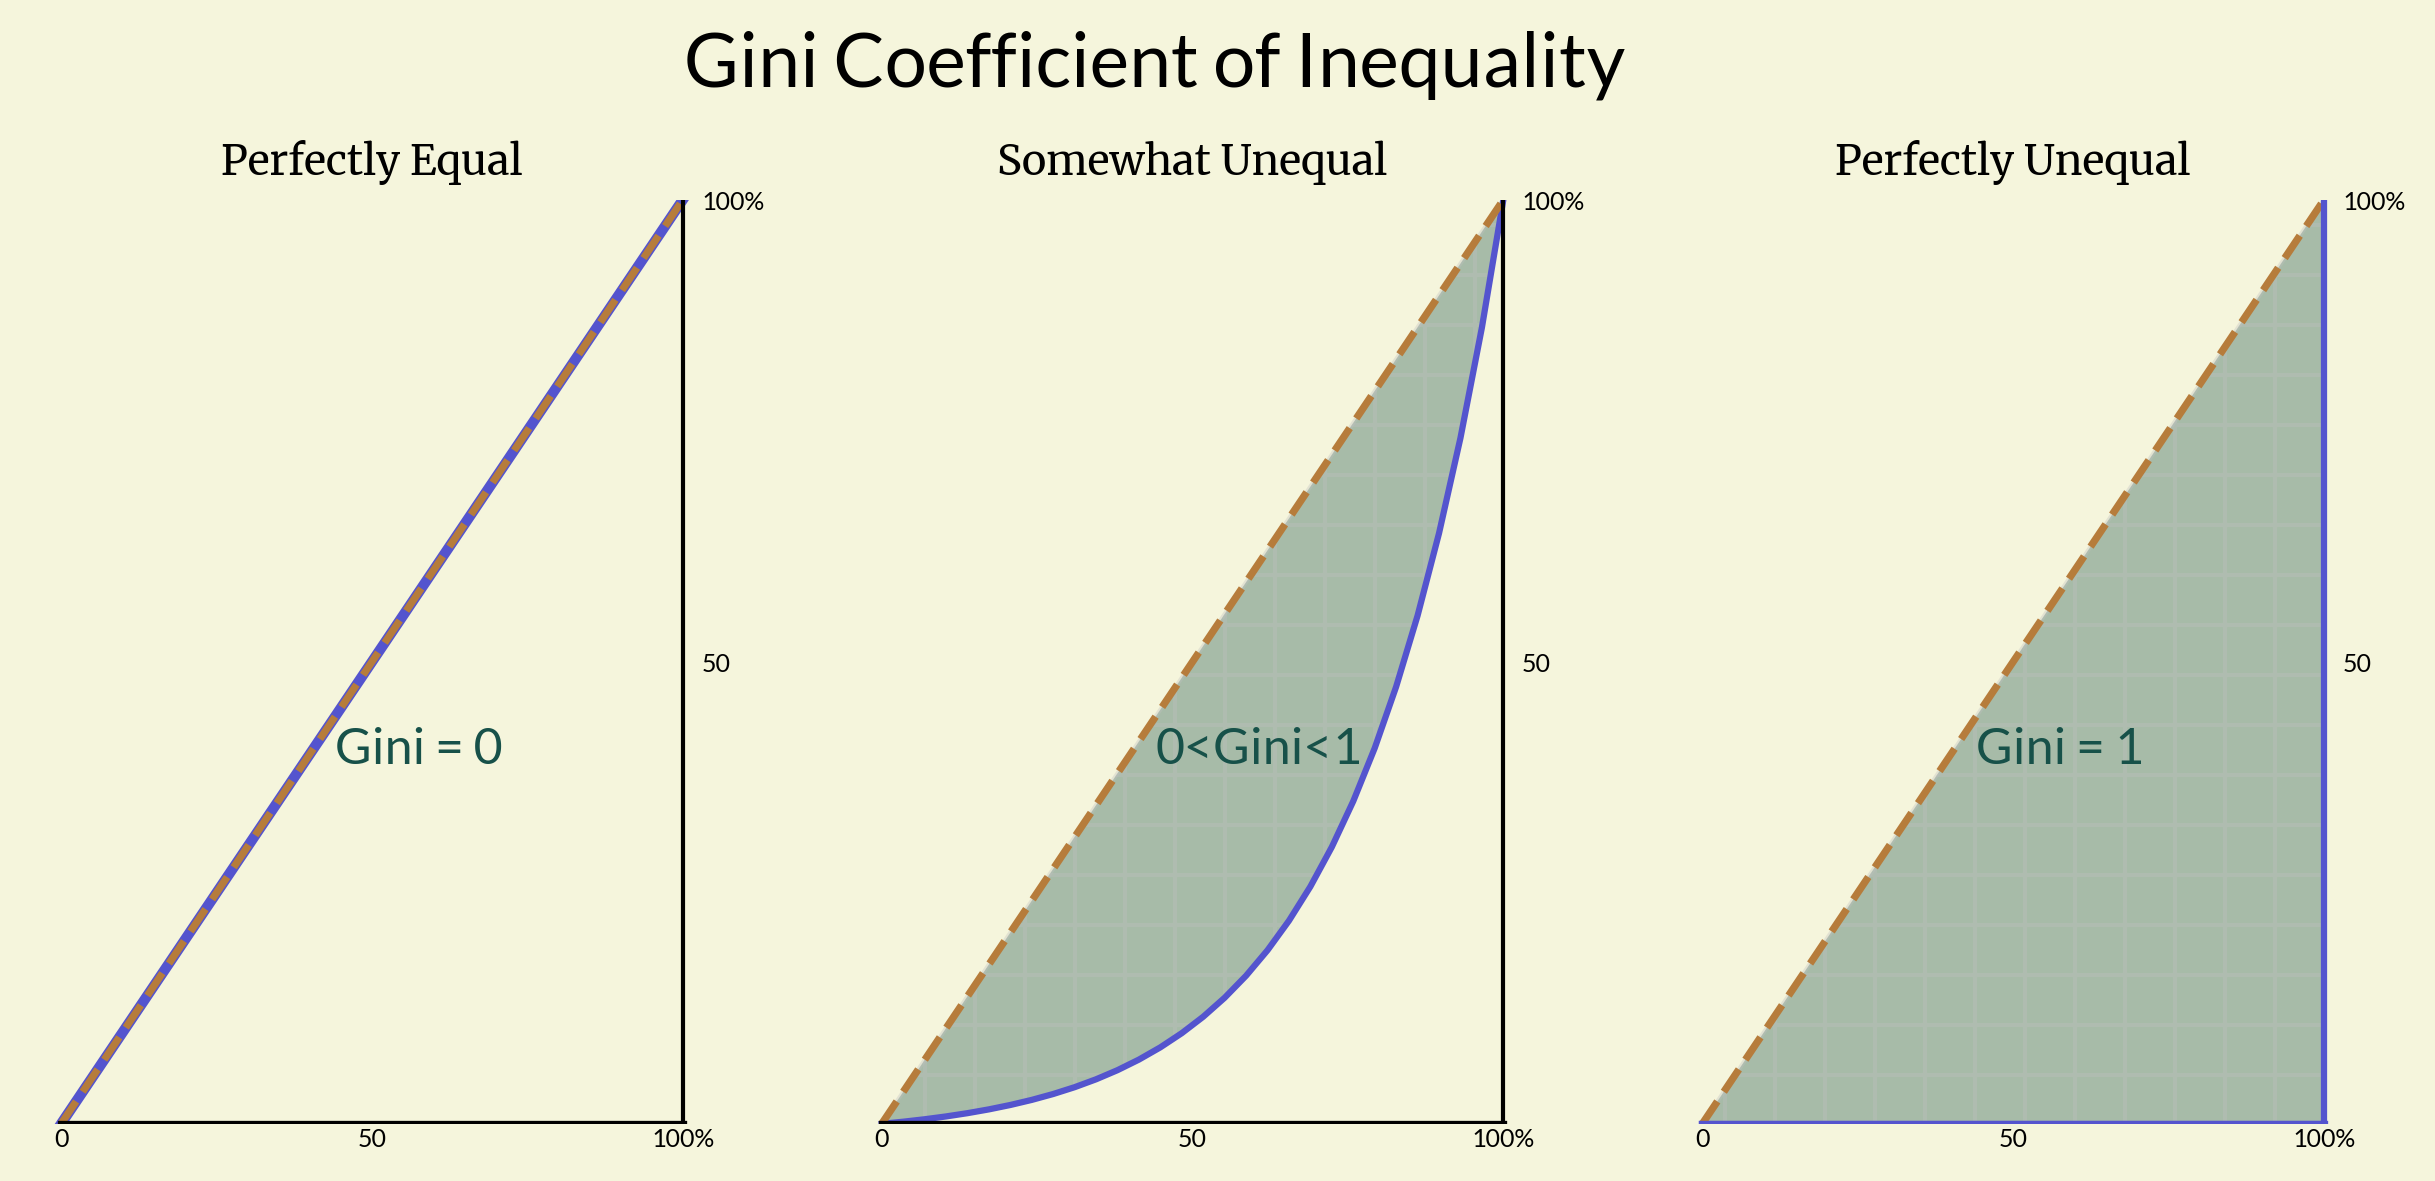

In [447]:
k = 4.25
lorenz = (np.exp(k * quin) - 1) / (np.exp(k) - 1)

fig, axs = plt.subplots(1,3, figsize = (10,4), dpi = 300)
lines = [per, lorenz, imper]

for i, (ax, line) in enumerate(zip(axs,lines)):
    ax.plot(quin,line, color = default_c,             # lorenz line
           lw = 2.5 if i == 0 else 1.5)       
    ax.plot(quin, per, lw = 1.75, ls = '--',          # perfect line
            color = cmap.colors[-3])
    ax.plot(quin, imper, lw = 1.75,                   # X line
            color = default_c if i == 2 else 'k')
    ax.vlines(1,0,1,                                  # Y line
              color = default_c if i == 2 else 'k', 
              lw = 1.5 if i == 2 else 1)
    
    ticks = {'font':font, 'fontsize' : 6}
    ax.set_yticks(np.arange(0.5,1.2,0.5),[50,'100%'], **ticks)
    ax.set_xticks(np.arange(0,1.2,0.5),[0,50,'100%'], **ticks)
    ax.tick_params(pad = 1, length = 0)  
    ax.tick_params(axis = 'y', pad = -3)  
    ax.set_ylim(0,1)
    ax.yaxis.tick_right()
    ax.spines[:].set_visible(False)
    ax.set_facecolor(background_c)

titles = ['Perfectly Equal','Somewhat Unequal','Perfectly Unequal']
callouts = ['Gini = 0','0<Gini<1', 'Gini = 1']
for i, (title,callout) in enumerate(zip(titles, callouts)):
    axs[i].set_title(label = title, 
                     font = subheader)
    axs[i].text(x= 0.44, y = 0.39, s = callout, 
                c = cmap.colors[-2], rotation =0, 
                size = 12, font = font)
    
axs[1].fill_between(per, per, lorenz, alpha=0.35, color = cmap.colors[-2],
                 hatch = '+', edgecolor='silver')
axs[2].fill_between(per, per, imper, alpha=0.35, color = cmap.colors[-2],
                 hatch = '+', edgecolor='silver')


fig.text(x = 0.5, y = 0.975, 
         s = "Gini Coefficient of Inequality", 
         font = font, fontsize = 18, ha='center')
fig.set_facecolor(background_c)

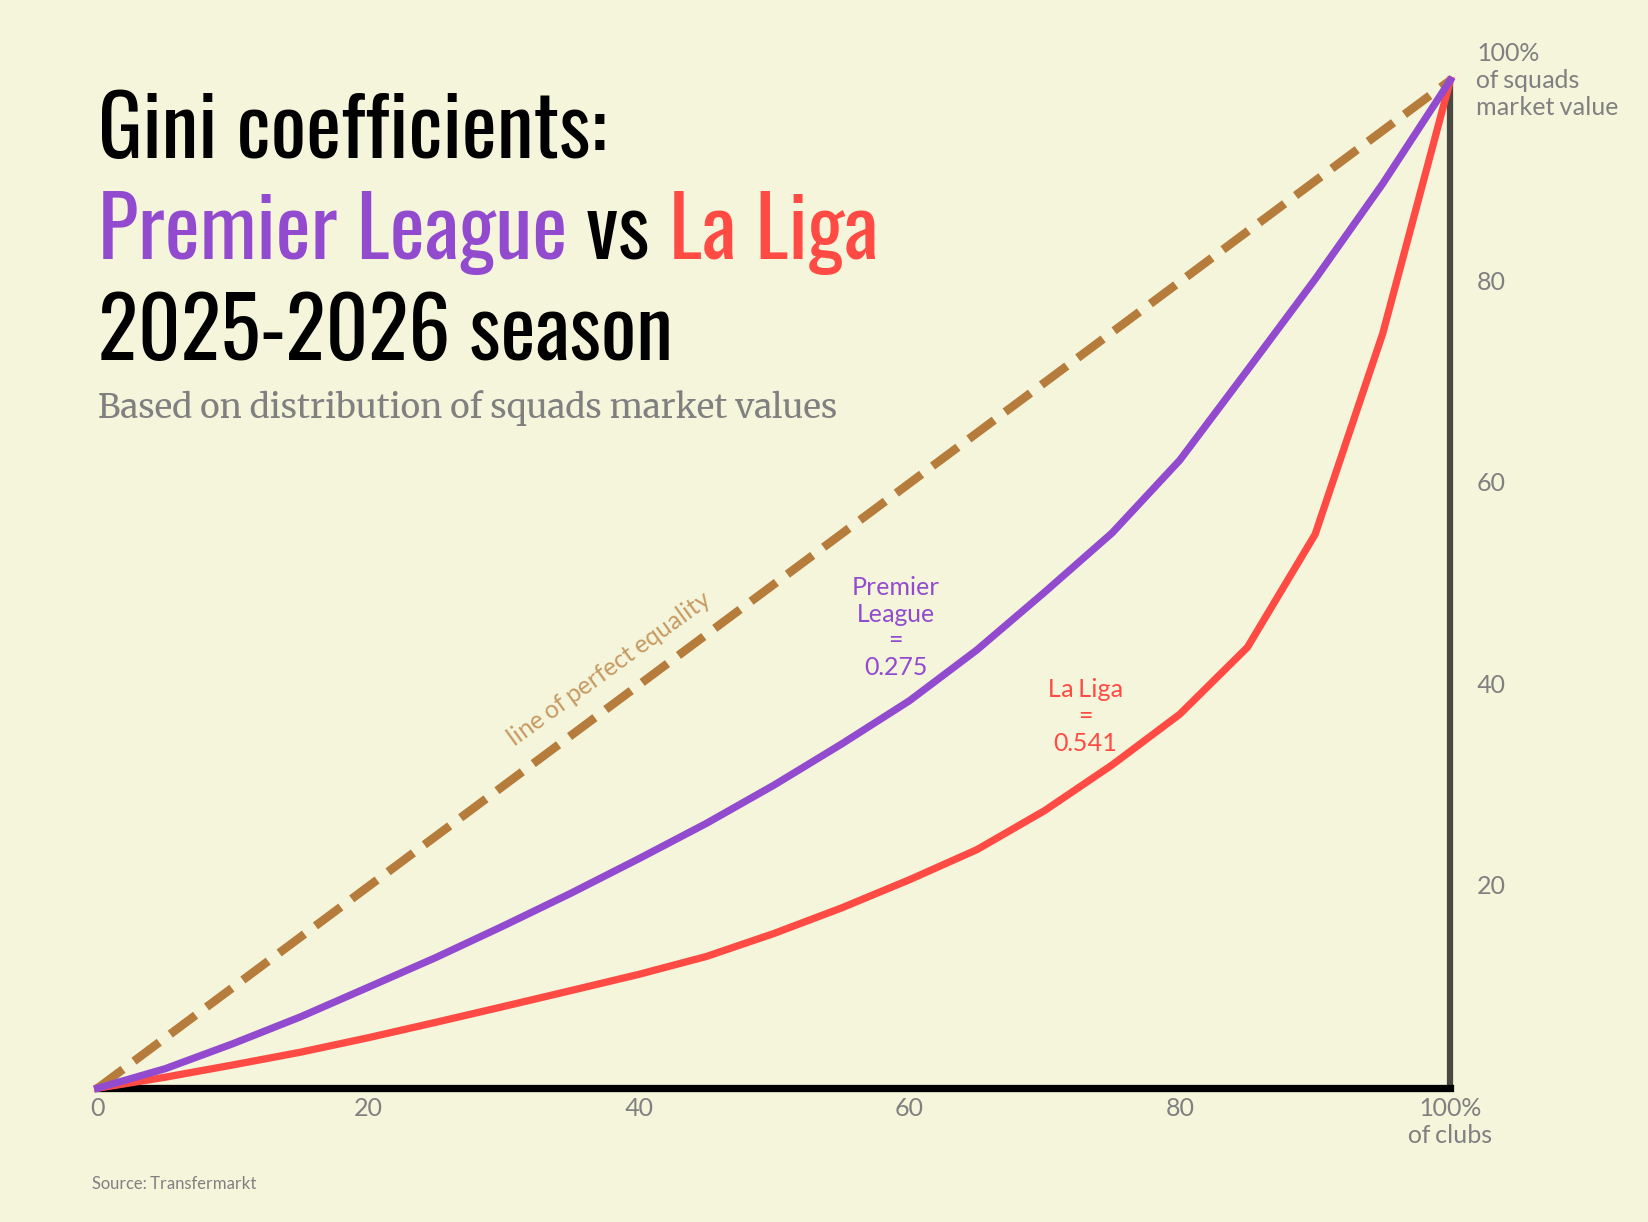

In [477]:
per = np.linspace(0, 1, 21)
imper = np.array([0]*21)
quin = np.linspace(0, 1, 21) #quin = quintiles

la_liga_cumsum = ((dfs['La Liga']['25/26'].dropna().sort_values()
) / 
 dfs['La Liga']['25/26'].sum()).cumsum()
la_liga_cumsum = pd.concat([pd.Series([0]),la_liga_cumsum])

epl_cumsum = ((dfs['Premier League']['25/26'].dropna().sort_values()
) / 
 dfs['Premier League']['25/26'].sum()).cumsum()
epl_cumsum = pd.concat([pd.Series([0]),epl_cumsum])


fig, ax = plt.subplots(dpi = 300)


ax.plot(quin, per, lw = 2.05, 
        ls = '--', color = cmap.colors[-3])
ax.text(x= 0.3, y = 0.34, s = 'line of perfect equality', c = cmap.colors[-3], rotation =36, size = 6,
        font = font, alpha = 0.75)

ax.plot(quin, imper, lw = 1.75, color = 'k')
ax.vlines(1,0,1, color = 'black', alpha = 0.7)

ax.plot(quin, la_liga_cumsum,
        lw = 1.75, color = league_colors[-3])
ax.text(0.73,0.335,'La Liga\n=\n0.541', 
        font = font, color = league_colors[-3], 
        fontsize = 6, ha = 'center')
ax.plot(quin, epl_cumsum,
        lw = 1.75, color = league_colors[-2])
ax.text(0.59,0.41,'Premier\nLeague\n=\n0.275', 
        font = font, color = league_colors[-2], 
        fontsize = 6, ha = 'center')

ax.set_yticks(np.arange(0,1.1,0.1),
              ['','',20,'',40,'',60,'',80,'','100%\nof squads\nmarket value'], 
              va = 'center', font = font, fontsize = 6, color = 'grey')
ax.set_xticks(np.arange(0,1.1,0.1),
              [0,'',20,'',40,'',60,'',80,'','100%\nof clubs'], 
              font = font, fontsize = 6, color = 'grey')


ax.yaxis.set_label_position("right")
ax.yaxis.label.set(rotation='horizontal', ha='left')
ax.yaxis.tick_right()
ax.tick_params(pad = -10, length = 0)
ax.spines[:].set_visible(False)

ax_text(0, 0.99, 'Gini coefficients:\n<Premier League> vs <La Liga>\n2025-2026 season',
        highlight_textprops=[{'color':league_colors[-2]}, {'color':league_colors[-3]}],
       ha = 'left', font = title, fontsize = 20)

ax_text(0, 0.6925, 'Based on distribution of squads market values',
       ha = 'left', font = subheader, fontsize = 8, color = 'grey')

fig.text(0.2,0.075, s = "Source: Transfermarkt",
           ha = 'center', font = font, fontsize = 4, color = 'grey')


ax.set_facecolor(background_c)
fig.set_facecolor(background_c)

## Bar charts

### Top teams

In [394]:
barchart = pd.concat([dfs[league]
           ['25/26']
           .dropna()
           .sort_values(ascending = False) 
                        for league in dfs]
                    ).nlargest(10)

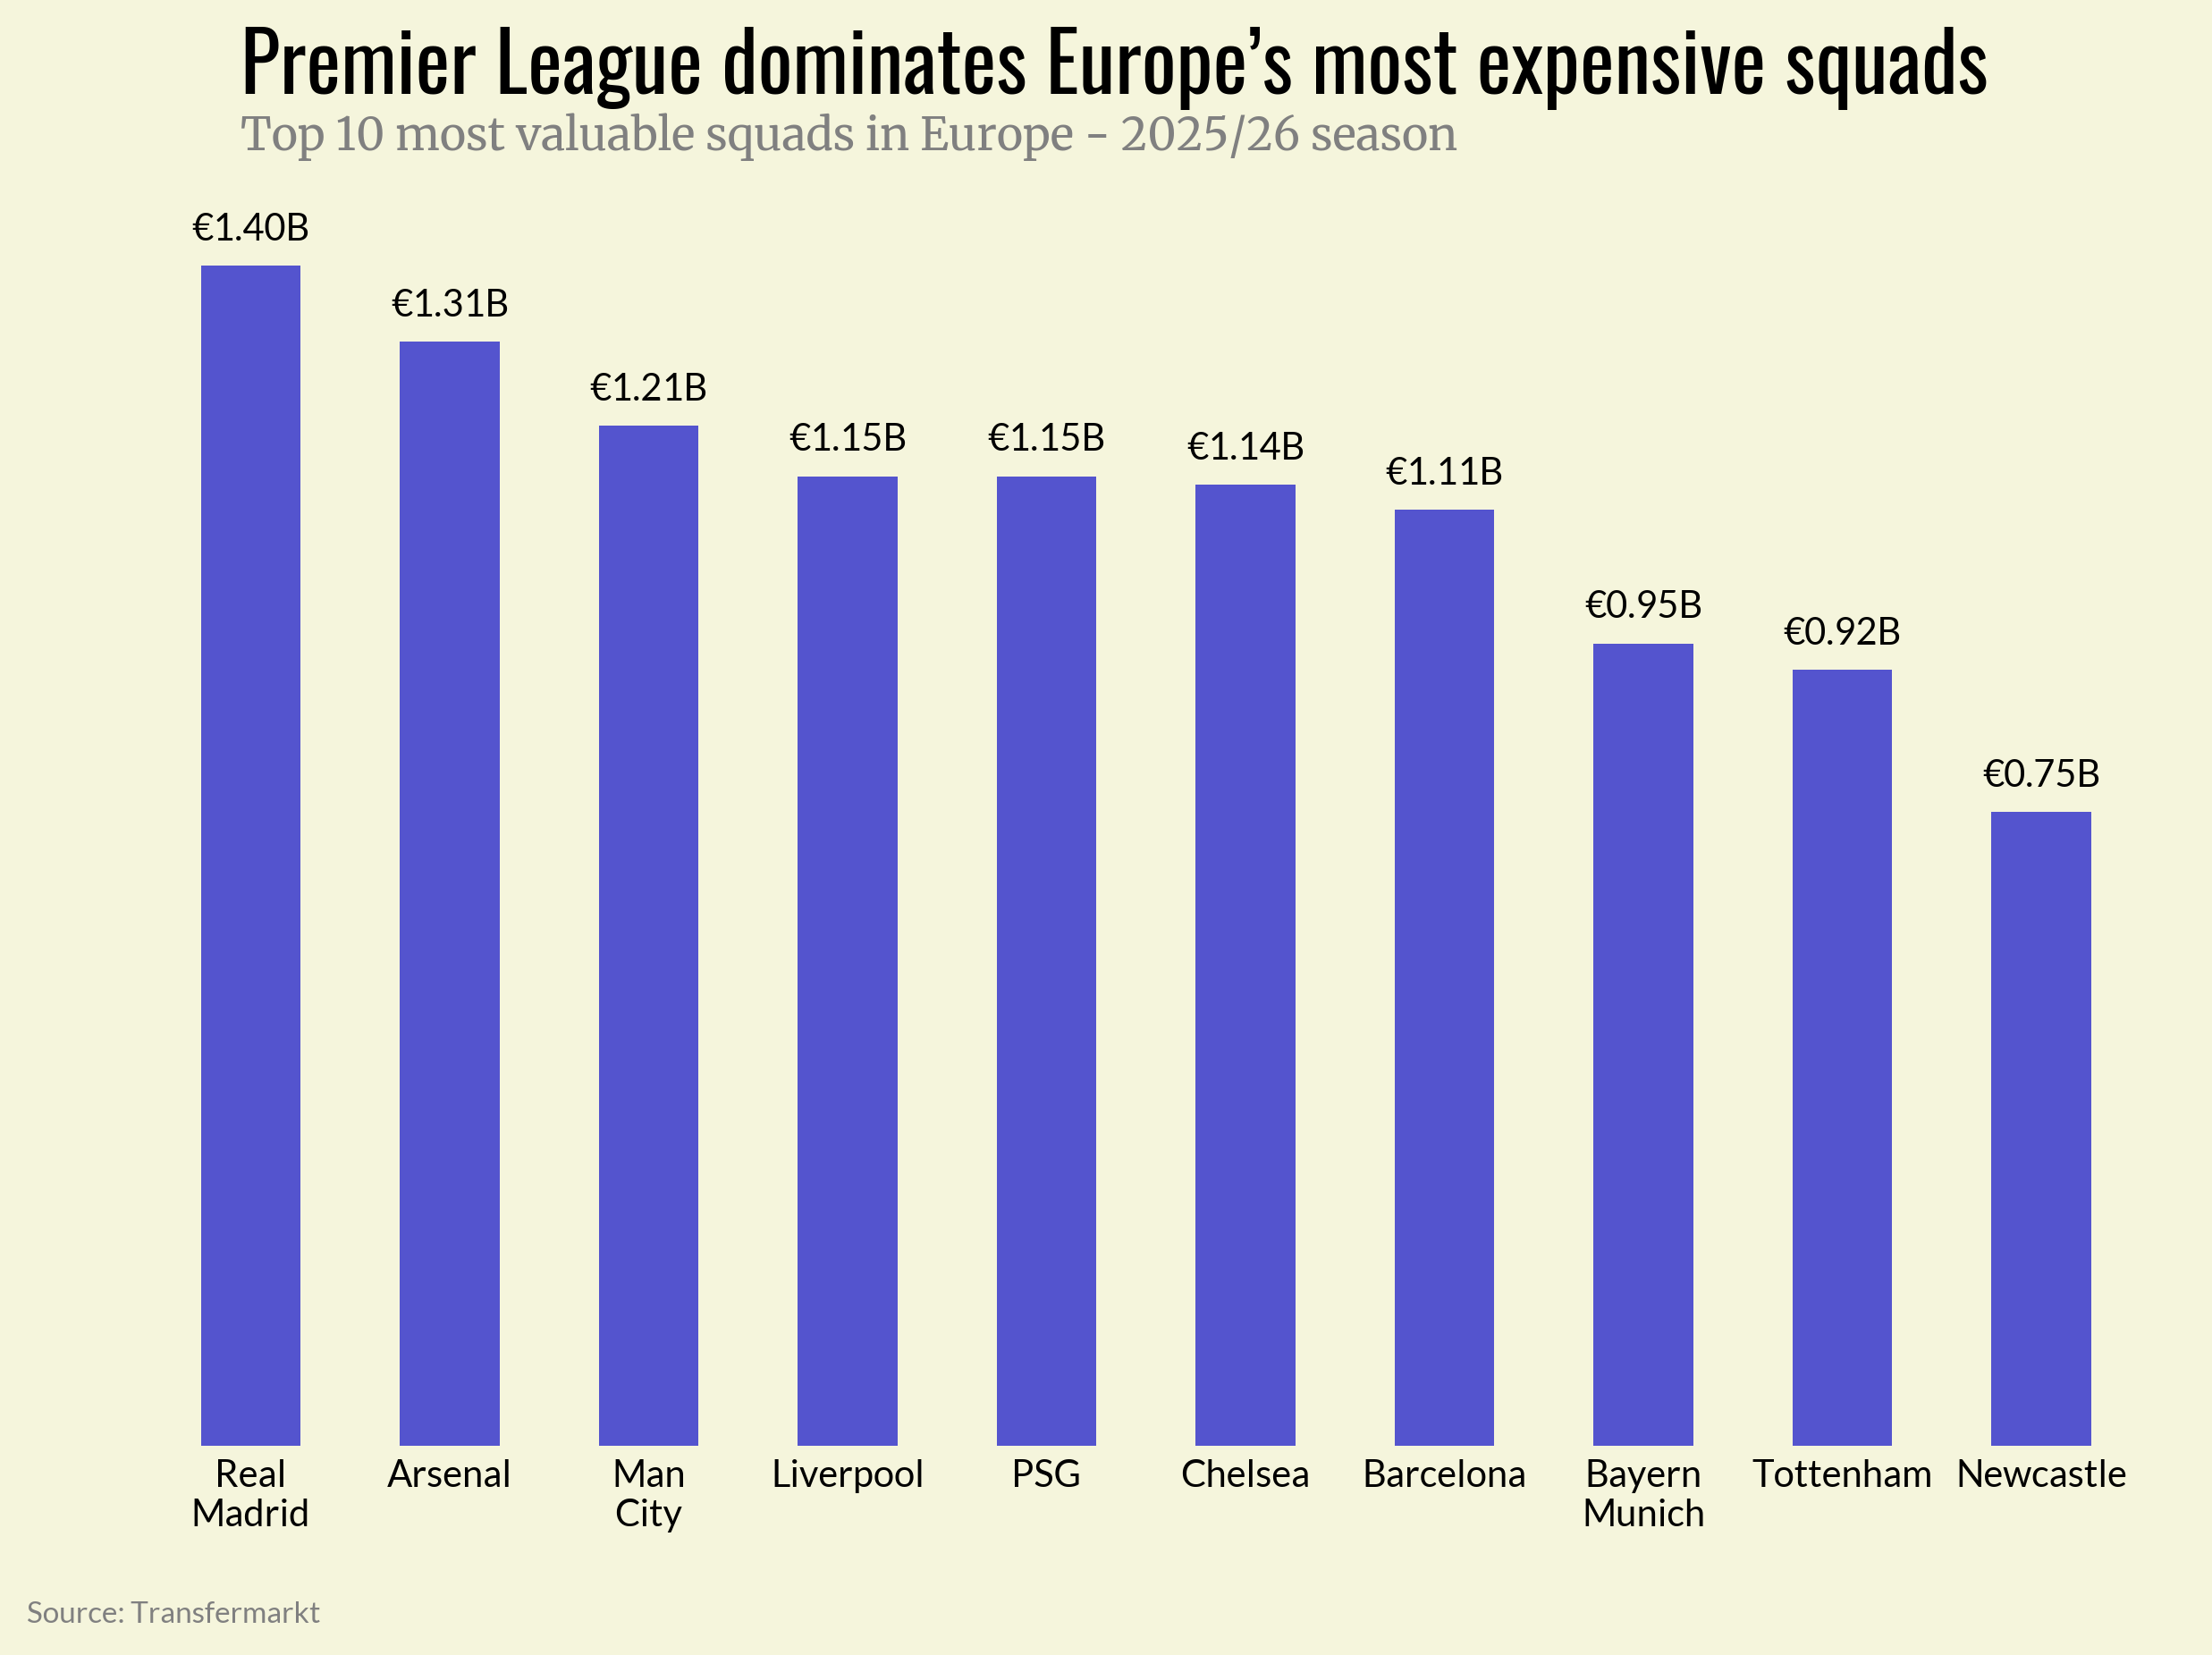

In [421]:
import matplotlib.pyplot as plt

# Top-10 data
clubs = barchart.index
clubs = (
    pd.Series(clubs)
    .str.replace('FC','')
    .str.strip()
    .str.replace(' ','\n')
    .str.replace('Paris\nSaint-Germain','PSG')
    .str.replace('Tottenham\nHotspur','Tottenham')
    .str.replace('Newcastle\nUnited','Newcastle')
    .str.replace('Manchester\nCity','Man\nCity')
)
values = barchart.values
values = [v / 1000 for v in values] 
# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)

ax.bar(clubs, values, width = 0.5, color = '#5454CE')

# Labels & title
#ax.set_xlabel("Squad Value (million €)")
#ax.set_title("Top 10 Squad Values – 2025/26 Season")

# Make values appear next to bars
for i, v in enumerate(values):
    ax.text(i, v + 0.03, f"€{v:.2f}B", ha="center", font = font)

ax.spines[:].set_visible(False)
ax.set_yticks([])
ax.tick_params(length = 0)
ax.set_xticks(range(len(clubs)))
ax.set_xticklabels(clubs, font=font)
ax.set_facecolor('#F5F5DC')
fig.set_facecolor('#F5F5DC')
fig.text(0.175,0.95, s = 'Premier League dominates Europe’s most expensive squads',
           ha = 'left', font = title, fontsize = 22)
fig.text(0.175,0.915, s = "Top 10 most valuable squads in Europe - 2025/26 season",
           ha = 'left', font = subheader, fontsize = 12, color = 'grey')
fig.text(0.15,0, s = "Source: Transfermarkt",
           ha = 'center', font = font, fontsize = 8, color = 'grey')
plt.show()


### Top countries

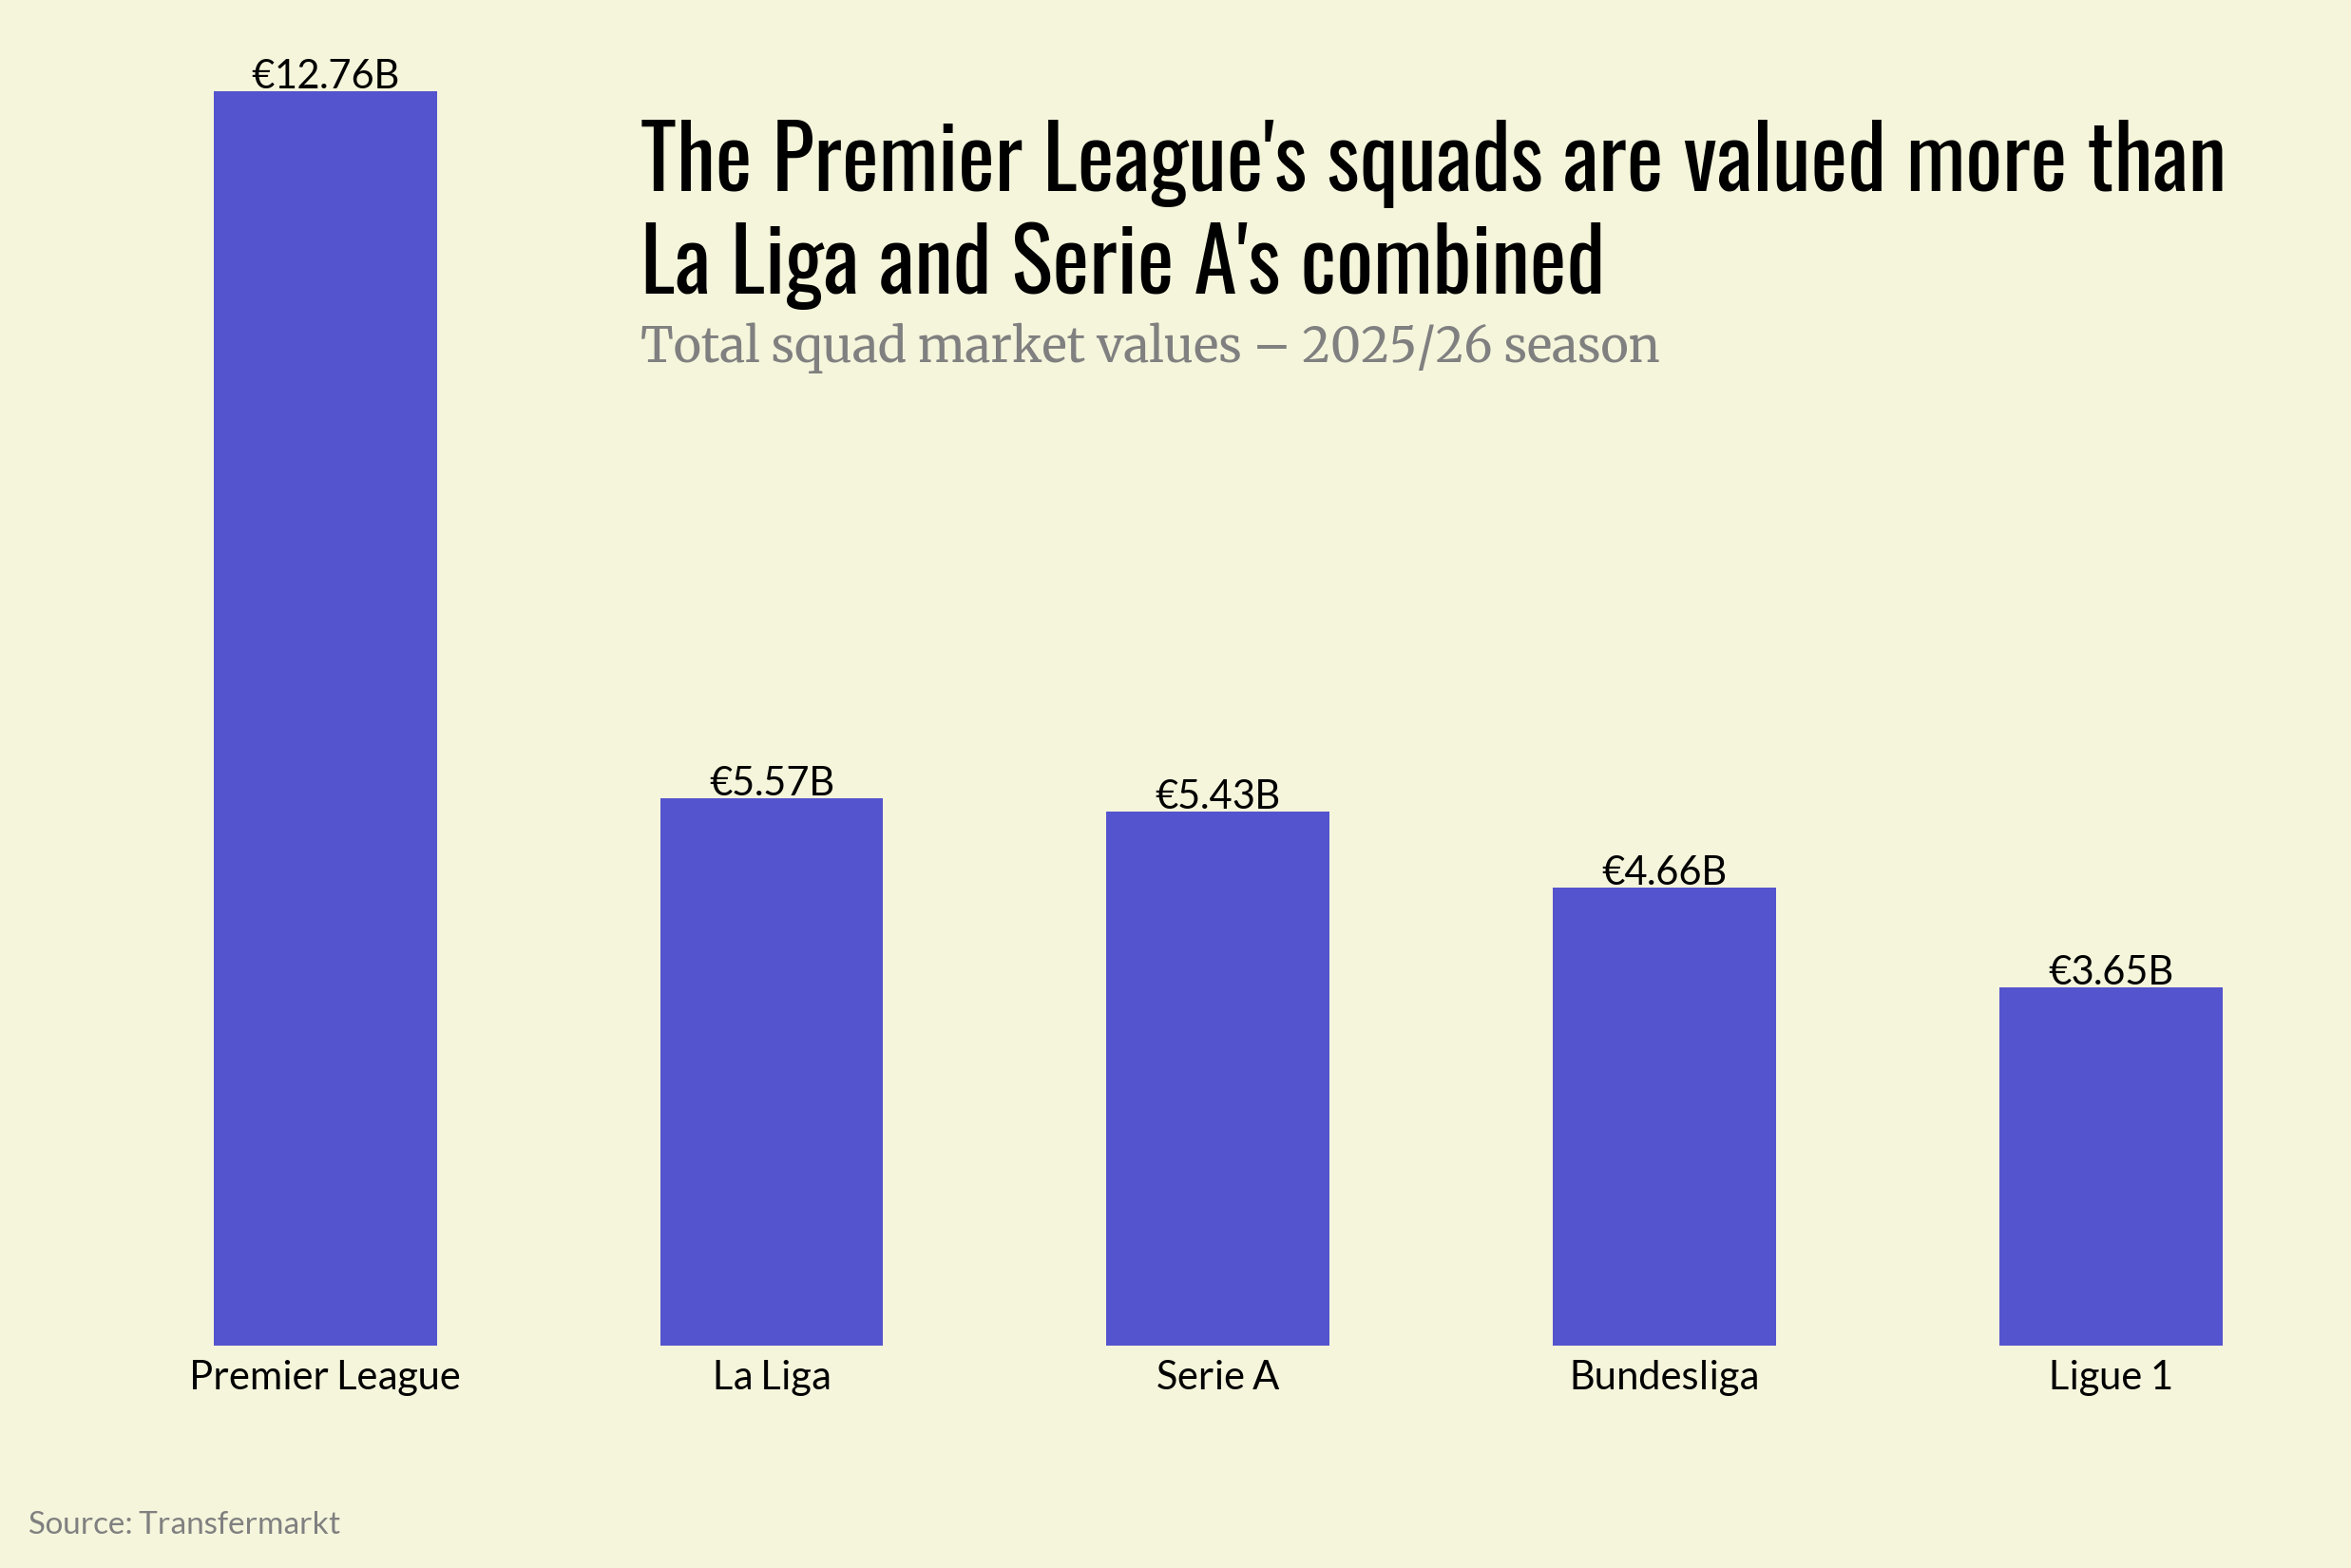

In [422]:
coutnries = (
    pd.Series(
        {league: dfs[league]['25/26']
                 .dropna()
                 .sum()/1000 
        for league in dfs})
    .sort_values(ascending = False)
)

fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)

ax.bar(coutnries.index, coutnries.values, width = 0.5, 
       color = '#5454CE')

# Labels & title
#ax.set_xlabel("Squad Value (million €)")
#ax.set_title("Top 10 Squad Values – 2025/26 Season")

# Make values appear next to bars
for i, v in enumerate(coutnries.values):
    ax.text(i, v + 0.03, f"€{v:.2f}B", ha="center", font = font)

ax.spines[:].set_visible(False)
ax.set_yticks([])
ax.tick_params(length = 0)
ax.set_xticks(range(len(coutnries)))
ax.set_xticklabels(coutnries.index, font=font)
ax.set_facecolor('#F5F5DC')
fig.set_facecolor('#F5F5DC')
# 
fig.text(0.31,0.725, s = "The Premier League's squads are valued more than\nLa Liga and Serie A's combined",
           ha = 'left', font = title, fontsize = 22)
fig.text(0.31,0.685, s = 'Total squad market values – 2025/26 season',
           ha = 'left', font = subheader, fontsize = 12, color = 'grey')
fig.text(0.15,0, s = "Source: Transfermarkt",
           ha = 'center', font = font, fontsize = 8, color = 'grey')
plt.show()
